# What Is the Relationship between Housing Characteristics and Complaints?

## The goal of this exercise is to find the answer to the Question 3 of the problem statement: 

## Does the Complaint Type that you identified in response to Question 1 have an obvious relationship with any particular characteristic or characteristic of the Houses?

## My approach to this exercise will be to carry out the following:

### -First, as per the previous two exercise prompts, this exercise will be focused on heat/hot water complaints in the Bronx.

### -Create and analyze a correlation matrix with the recommended features from the prompt and produce a heat map for visual analysis of the features.

### -Use the XGBoost feature importance classifer function to generate a feature importance graph and numerical ranking.

### -Use the random forest regressor default feature importance function from scikit learn to create a graph and numerical ranking of features.

In [25]:
#loading libraries

import pandas as pd
import numpy as np

# Loading Pluto data set.

file_path = "../Capstone/pluto_19v1.csv"
df1 = pd.read_csv(file_path, parse_dates=True, dtype={"zonedist2": str, "zonedist3": str, "zonedist4": str, "overlay2": str, "spdist2": str})

In [6]:
# loading 311 data set
filename = 'https://data.cityofnewyork.us/resource/fhrw-4uyv.csv?$limit=100000000&Agency=HPD&$select=created_date,unique_key,complaint_type,incident_zip,incident_address,street_name,address_type,city,resolution_description,borough,latitude,longitude,closed_date,location_type,status'
df2 = pd.read_csv(filename, parse_dates=True)

In [26]:
# Selecting recommended features from the pluto data set
dfA = pd.DataFrame(df1, columns=['address', 'borough', 'bldgarea', 'bldgdepth', 'builtfar', 'commfar', 'facilfar', 'lot', 'lotarea', 'lotdepth', 'numbldgs', 'numfloors', 'officearea', 'resarea', 'residfar', 'retailarea', 'yearbuilt', 'yearalter1', 'zipcode', 'ycoord', 'xcoord'])
dfA.head()

,address,borough,bldgarea,bldgdepth,builtfar,commfar,facilfar,lot,lotarea,lotdepth,...,numfloors,officearea,resarea,residfar,retailarea,yearbuilt,yearalter1,zipcode,ycoord,xcoord
0,801 11 AVENUE,MN,57805.0,125.0,2.16,2.0,0.0,36,26817.0,150.00,...,3.0,0.0,0.0,0.0,12000.0,1920.0,2006.0,10019.0,219627.0,986332.0
1,PIER,MN,105562.0,0.0,0.61,2.0,0.0,100,172842.0,266.75,...,0.0,0.0,0.0,0.0,0.0,2002.0,0.0,10019.0,219475.0,985279.0
2,80 CENTRAL PARK WEST,MN,225552.0,172.0,15.03,0.0,10.0,29,15002.0,174.29,...,24.0,7000.0,194052.0,10.0,0.0,1968.0,0.0,10023.0,221271.0,990305.0
3,631 WEST 51 STREET,MN,36184.0,200.0,4.00,5.0,0.0,12,9050.0,200.83,...,4.0,0.0,0.0,0.0,0.0,1946.0,0.0,10019.0,218920.0,985450.0
4,1073 66 STREET,BK,3600.0,57.0,1.80,0.0,2.0,49,2000.0,100.00,...,2.0,0.0,2400.0,2.0,0.0,1930.0,0.0,11219.0,168230.0,982378.0


In [27]:
dfB = pd.DataFrame(df2, columns=['complaint_type', 'incident_address']) # selecting the target variable and variable shared between data sets.
dfB.columns = ['complaint_type','address'] # changing incident_addess variable to address to match data frame A.
dfB.head()

,complaint_type,address
0,PLUMBING,539 WEST 152 STREET
1,UNSANITARY CONDITION,175 EAST 52 STREET
2,FLOORING/STAIRS,114-05 170 STREET
3,UNSANITARY CONDITION,1092 WILLMOHR STREET
4,UNSANITARY CONDITION,646 EAST 231 STREET


In [28]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
dfB.columns = ['complaint_type','address'] # changing incident_addess variable to address to match data frame A.
dfB.head()

,complaint_type,address
0,PLUMBING,539 WEST 152 STREET
1,UNSANITARY CONDITION,175 EAST 52 STREET
2,FLOORING/STAIRS,114-05 170 STREET
3,UNSANITARY CONDITION,1092 WILLMOHR STREET
4,UNSANITARY CONDITION,646 EAST 231 STREET


In [30]:
addresses = dfB[(dfB["complaint_type"]=="HEAT/HOT WATER")]["address"] # Filtering for addresses with the target complaint type of HEAT/HOT WATER
uni_ads = set(addresses) # Getting rid of duplicate observations.
# Creating a new dummy column in the pluto data frame where heat_problem = 1 if the addresses between 311 and pluto match, else heat_problem = 0
dfA["heat_problem"] = dfA["address"].apply(lambda x: 1 if x in uni_ads else 0)
dfA.head()

,address,borough,bldgarea,bldgdepth,builtfar,commfar,facilfar,lot,lotarea,lotdepth,numbldgs,numfloors,officearea,resarea,residfar,retailarea,yearbuilt,yearalter1,zipcode,ycoord,xcoord,heat_problem
0,801 11 AVENUE,MN,57805.0,125.0,2.16,2.0,0.0,36,26817.0,150.00,2.0,3.0,0.0,0.0,0.0,12000.0,1920.0,2006.0,10019.0,219627.0,986332.0,0
1,PIER,MN,105562.0,0.0,0.61,2.0,0.0,100,172842.0,266.75,1.0,0.0,0.0,0.0,0.0,0.0,2002.0,0.0,10019.0,219475.0,985279.0,0
2,80 CENTRAL PARK WEST,MN,225552.0,172.0,15.03,0.0,10.0,29,15002.0,174.29,1.0,24.0,7000.0,194052.0,10.0,0.0,1968.0,0.0,10023.0,221271.0,990305.0,1
3,631 WEST 51 STREET,MN,36184.0,200.0,4.00,5.0,0.0,12,9050.0,200.83,1.0,4.0,0.0,0.0,0.0,0.0,1946.0,0.0,10019.0,218920.0,985450.0,0
4,1073 66 STREET,BK,3600.0,57.0,1.80,0.0,2.0,49,2000.0,100.00,1.0,2.0,0.0,2400.0,2.0,0.0,1930.0,0.0,11219.0,168230.0,982378.0,0


In [31]:
import numpy as np
dfA= dfA[dfA['borough']=="BX"] # Focusing in on the bronx
missing_data = dfA.isnull()
missing_data.head(5)
dfA.replace("?", np.nan, inplace = True) # Cleaning missing data

In [32]:
# Listing Missing Values
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("")

address
False    89675
True        84
Name: address, dtype: int64

borough
False    89759
Name: borough, dtype: int64

bldgarea
False    89674
True        85
Name: bldgarea, dtype: int64

bldgdepth
False    89666
True        93
Name: bldgdepth, dtype: int64

builtfar
False    89423
True       336
Name: builtfar, dtype: int64

commfar
False    89675
True        84
Name: commfar, dtype: int64

facilfar
False    89675
True        84
Name: facilfar, dtype: int64

lot
False    89759
Name: lot, dtype: int64

lotarea
False    89666
True        93
Name: lotarea, dtype: int64

lotdepth
False    89666
True        93
Name: lotdepth, dtype: int64

numbldgs
False    89666
True        93
Name: numbldgs, dtype: int64

numfloors
False    89666
True        93
Name: numfloors, dtype: int64

officearea
False    82549
True      7210
Name: officearea, dtype: int64

resarea
False    82549
True      7210
Name: resarea, dtype: int64

residfar
False    89675
True        84
Name: residfar, dtype: int64

retaila

In [33]:
# A small proportion of rows have missing data, so I'm okay with dropping them instead of imputing.
dfA.dropna(inplace=True)
dfA.reset_index(drop=True, inplace=True)

In [34]:
dfA.head() # Checking on data frame after changes to make sure index is okay.

,address,borough,bldgarea,bldgdepth,builtfar,commfar,facilfar,lot,lotarea,lotdepth,numbldgs,numfloors,officearea,resarea,residfar,retailarea,yearbuilt,yearalter1,zipcode,ycoord,xcoord,heat_problem
0,365 EAST 169 STREET,BX,2000.0,57.00,1.12,0.0,4.8,66,1778.0,90.00,1.0,2.00,0.0,2000.0,3.44,0.0,1901.0,2005.0,10456.0,243406.0,1009022.0,0
1,3011 LACONIA AVENUE,BX,960.0,24.00,0.38,0.0,2.0,52,2500.0,100.00,1.0,2.00,0.0,960.0,1.25,0.0,1930.0,0.0,10469.0,256247.0,1024076.0,0
2,824 SOUTHERN BOULEVARD,BX,41874.0,87.00,4.19,0.0,4.8,8,10000.0,100.00,1.0,6.00,0.0,41874.0,3.44,0.0,1923.0,2004.0,10459.0,236856.0,1013223.0,1
3,3270 WATERBURY AVENUE,BX,1318.0,37.67,0.29,0.0,1.0,39,4468.0,71.75,1.0,1.75,0.0,1318.0,0.50,0.0,1930.0,0.0,10465.0,244251.0,1034250.0,0
4,414 EAST 138 STREET,BX,3633.0,82.00,1.45,0.0,4.8,11,2500.0,100.00,1.0,1.00,0.0,0.0,2.43,3633.0,1986.0,2004.0,10454.0,233888.0,1005712.0,0


In [35]:
# Dropping unecessary features
dfA = dfA.drop('address', axis=1) # not numeric.  Geographic focus will be on the Bronx borough coordinates and zipcode.
dfA = dfA.drop('borough', axis=1) # Not numeric.  Dataframe has already been filtered to represent only the Bronx.

### Now we are ready to use the seaborn visualization library to produce our heatmap.

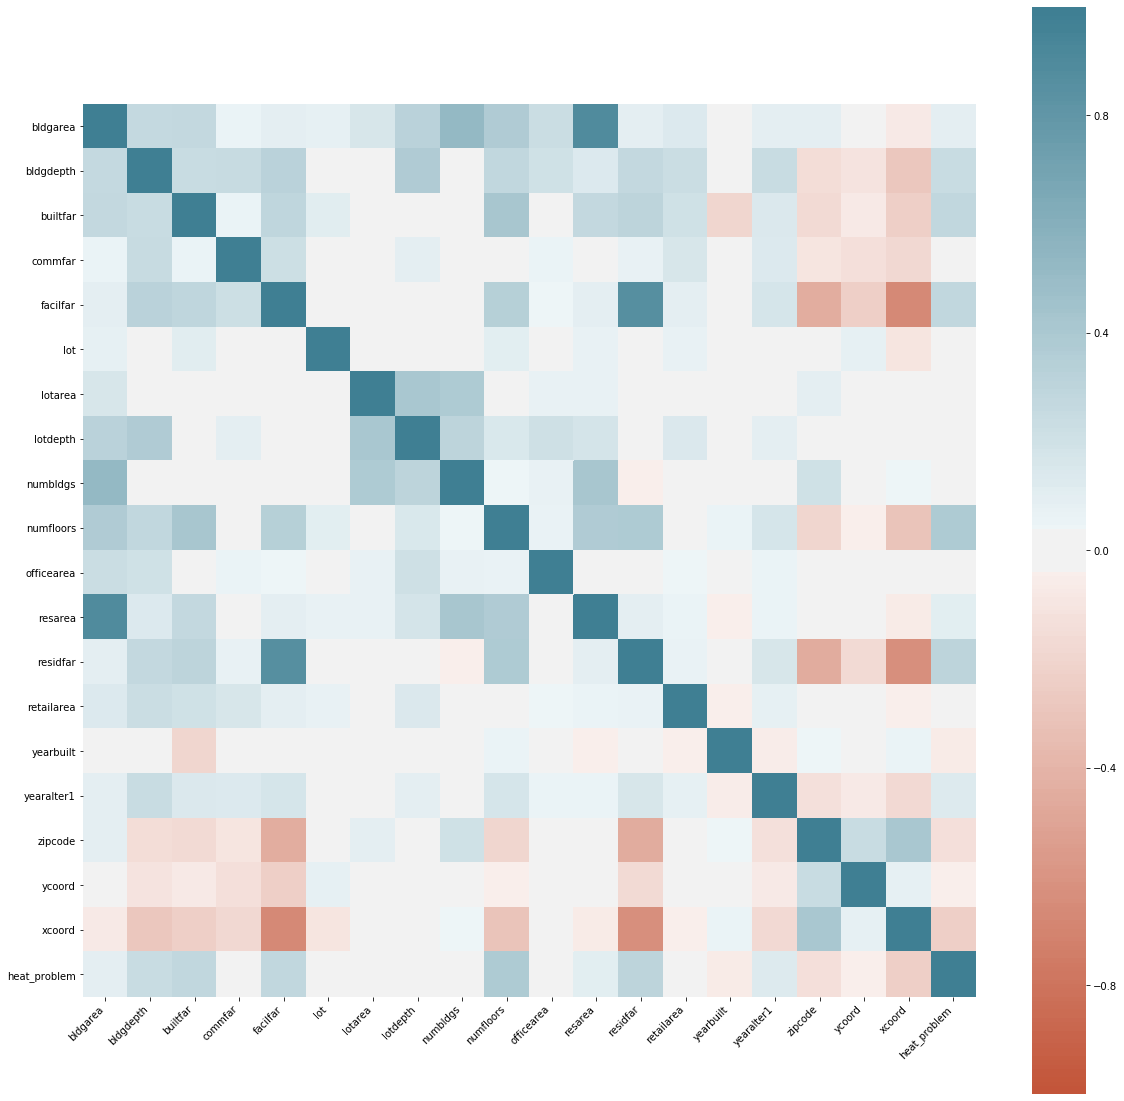

In [47]:
import seaborn as sns
corr = dfA.corr()
plt.figure(figsize=(20,20))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

## Top 8 selected features for correlation: 
## As is evident by the heatmap above and the correlation matrix below, our heat/hot water problem most strongly correlates to these variables:
### numfloors 0.386263
### residfar 0.309403
### builtfar 0.288223
### facilfar 0.287210
### bldgdepth 0.249327
### xcoord -0.232136
### yearalter1 0.130039
### resarea 0.102305

### It seems that the number of floors and amount residential area are the top two variables, and this makes sense, as with more floors you will have a larger building and an increased potential for heat/hot water problems throughout the building.  Larger residential area leads to more people, which would likely lead to more complaints.

In [36]:
dfA.corr() 

,bldgarea,bldgdepth,builtfar,commfar,facilfar,lot,lotarea,lotdepth,numbldgs,numfloors,officearea,resarea,residfar,retailarea,yearbuilt,yearalter1,zipcode,ycoord,xcoord,heat_problem
bldgarea,1.000000,0.258987,0.271523,0.051590,0.099861,0.079214,0.169218,0.322370,0.530160,0.368982,0.227156,0.892130,0.093368,0.135769,-0.030805,0.093730,0.092092,-0.021283,-0.077980,0.088569
bldgdepth,0.258987,1.000000,0.245156,0.256528,0.324192,-0.014261,0.031532,0.374288,0.032708,0.288403,0.206330,0.140303,0.268504,0.227548,-0.002910,0.242482,-0.149767,-0.113713,-0.281633,0.249321
builtfar,0.271523,0.245156,1.000000,0.051356,0.292631,0.115875,-0.005024,-0.004185,-0.032327,0.422583,0.033083,0.276347,0.304321,0.199883,-0.194952,0.145855,-0.167543,-0.072159,-0.238999,0.288200
commfar,0.051590,0.256528,0.051356,1.000000,0.221571,0.017079,0.009566,0.092355,0.003342,-0.012636,0.057366,-0.004243,0.077066,0.164367,-0.007993,0.133358,-0.103809,-0.135301,-0.181435,-0.003430
facilfar,0.099861,0.324192,0.292631,0.221571,1.000000,-0.019280,-0.010140,0.000688,-0.035360,0.335984,0.044409,0.086273,0.862433,0.090464,-0.029365,0.177680,-0.442950,-0.235839,-0.670639,0.287140
lot,0.079214,-0.014261,0.115875,0.017079,-0.019280,1.000000,0.008679,0.023193,-0.003258,0.103404,0.021884,0.073733,-0.002973,0.073163,0.017105,-0.011707,0.028572,0.085431,-0.104027,0.009034
lotarea,0.169218,0.031532,-0.005024,0.009566,-0.010140,0.008679,1.000000,0.416230,0.377646,0.028365,0.076899,0.072612,-0.009344,0.018128,-0.002064,0.024841,0.094712,0.001760,0.002446,-0.001043
lotdepth,0.322370,0.374288,-0.004185,0.092355,0.000688,0.023193,0.416230,1.000000,0.311539,0.151435,0.216489,0.185365,-0.014023,0.142510,0.005946,0.095932,0.029642,-0.017165,-0.036399,0.008755
numbldgs,0.530160,0.032708,-0.032327,0.003342,-0.035360,-0.003258,0.377646,0.311539,1.000000,0.040928,0.073620,0.428099,-0.041371,0.004940,-0.031480,0.021322,0.202761,-0.001346,0.046763,-0.019906
numfloors,0.368982,0.288403,0.422583,-0.012636,0.335984,0.103404,0.028365,0.151435,0.040928,1.000000,0.067447,0.373912,0.379057,0.009668,0.061050,0.173536,-0.197237,-0.044291,-0.301251,0.386236


### Now we're going to split up the data into x and y training and test groups as if we were getting ready to train a model.

In [51]:
# Feature Selection
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
X= dfA.drop('heat_problem', axis=1)
y= dfA['heat_problem']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=12345)

### We have X and Y defined now, so we will plot feature importance with the xgboost feature selection function.

<Figure size 1440x1440 with 0 Axes>

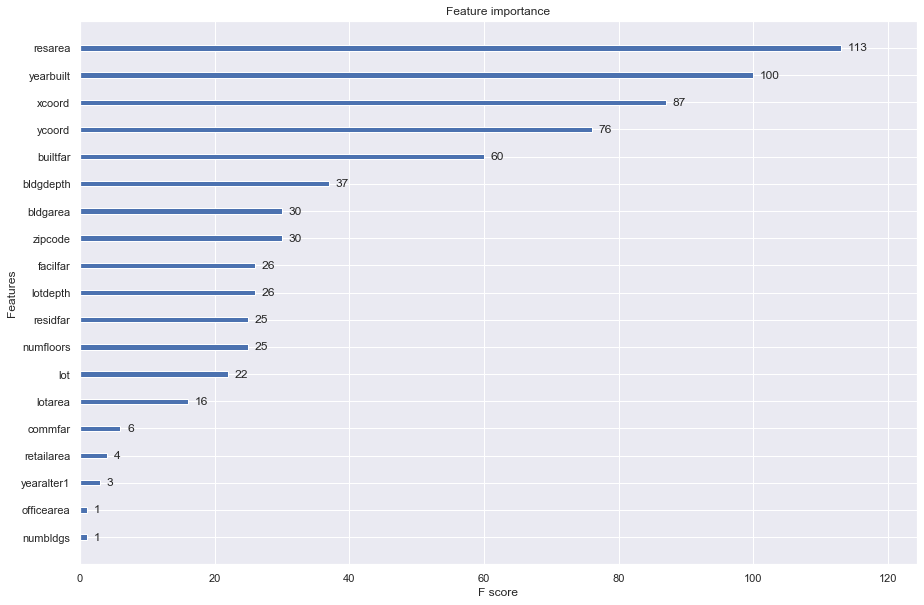

In [68]:
# plot feature importance using xgboost built-in function
!pip install xgboost
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
# fit model
model = XGBClassifier()
model.fit(X_train, y_train)
# plot feature importance
plt.figure(figsize=(20,20))
plot_importance(model)
pyplot.show()

### As can be seen by the feature importance analysis graph above, the xgboost feature importance function considers residential area and year built as the top two features by far.  This makes sense from a logical standpoint, as with more people you will have more complaints, and with an older building, your heating/hot water infrastructure will degrade with age.

### Next, we will be looking at features selected using the random forest regressor from sklearn.

In [63]:
# Random Forest Feature Selection
from sklearn.ensemble import RandomForestRegressor

# visualisations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("whitegrid")
sns.set(rc = {'figure.figsize':(15, 10)})

In [64]:
# function for creating a feature importance dataframe
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title):
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue') \
       .set_title(title, fontsize = 20)

In [65]:
# Importing random forest and fitting the model:

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 42)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=True, random_state=42, verbose=0,
                      warm_start=False)

In [66]:
print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(X_train, y_train), 
                                                                                    rf.oob_score_,
                                                                                    rf.score(X_train, y_train)))

R^2 Training Score: 0.90 
OOB Score: 0.27 
R^2 Validation Score: 0.90


### We have a low out of bag error along with high and consistent training/validation values for R squared.  This model should be effective.

### Next we will look at feature rankings and a visual plot of those values. 

In [67]:
base_imp = imp_df(X_train.columns, rf.feature_importances_)
base_imp

,feature,feature_importance
0,resarea,0.324684
1,ycoord,0.101529
2,xcoord,0.098951
3,lot,0.086363
4,builtfar,0.069325
5,yearbuilt,0.053396
6,bldgdepth,0.046538
7,lotarea,0.045836
8,bldgarea,0.044115
9,lotdepth,0.039529


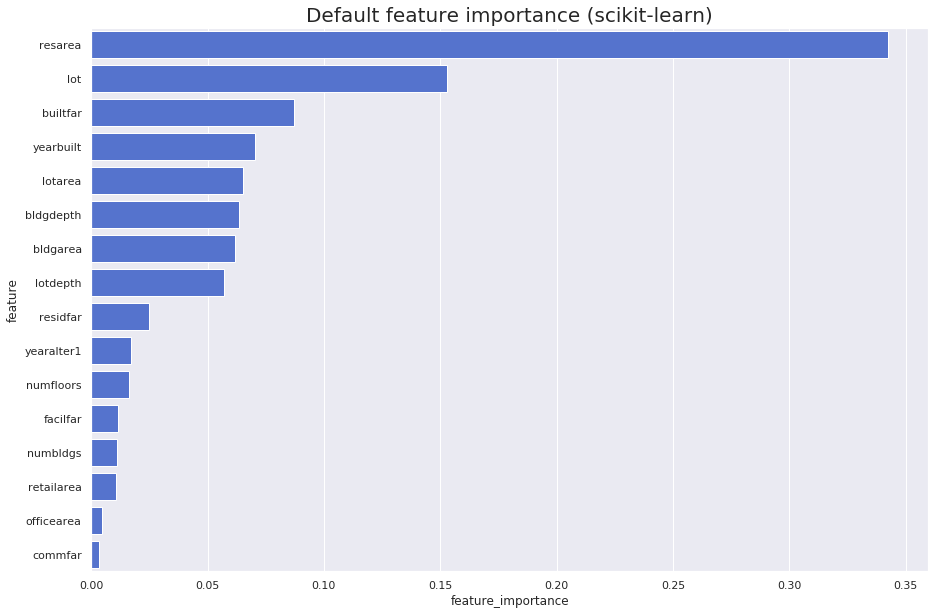

In [46]:
var_imp_plot(base_imp, 'Default feature importance (scikit-learn)')

### According to the feature importance plot from the random forest model, resarea is by far the most important feature, which has also ranked high with the other two algorithms.  After that we have lot, builtfar, and yearbuilt.  Residential area and year built make sense as explained in the previous two analyses.  Built Floor Area Ratio also makes sense, as a larger floor area would have more heat capacity and require substantial infrastructure to meet that capacity.  The lot variable actually represents tax lot identifiers. Each tax lot is unique within a tax block.  With said said, the final feature selection should probably exclude this column, as each number is unique and therefore not categorically useful.

# Conclusions and Remarks

##      Top 8 selected features for correlation: 

### numfloors 0.386263
### residfar 0.309403
### builtfar 0.288223
### facilfar 0.287210
### bldgdepth 0.249327
### xcoord -0.232136
### yearalter1 0.130039
### resarea 0.102305

##      Top 8 selected features for xgboost

### yearbuilt 130
### resarea 123 
### builtfar 67
### lot 55
### bldgdepth 55
### bldgarea 48
### residfar 39
### lotdepth 35

##      Top 8 selected features for random forest: 

### resarea 0.342527
### lot 0.152784
### builtfar 0.087290
### yearbuilt 0.070538
### lotarea 0.065334
### bldgdepth 0.063586
### bldgarea 0.061843
### lotdepth 0.056961

### All three techniques agree that builtfar, bldgdepth, and resarea have an important relationship to heat/hotwater complaints.  We've discussed in each of the three analyses how the residential area (resarea), and again, the building floor to area ratio (builtfar) would represent how much area on each floor is required to be heated.  Building depth (bldgdepth) is the vertical distance measurement of the building, which would relate to the heat capacity required for each building in a similar manner to the floor to area ratio or number of floors.  All of these variables have logical applications to predicting heat/hot water complaints.  Ultimately, each algorith and process is different, so feature selection techniques specific to those procedures would be the best overall approach to training these models.  